---
title: "Feature Selection for Record Data"
format:
    html:
        page-layout: full
        code-fold: show
        code-copy: true
        code-tools: true
        code-overflow: wrap
---

In this project, we’ll use feature selection to pinpoint and select the most crucial features from the dataset to address specific tasks. Feature selection can impact and improve the model’s performance, mitigate overfitting, contribute to noise reduction, and provide us with new insights to the data.

To carry out my feature selection, I first imported 3 data sets containing different information. The metadata_df contains data on a movie’s popularity, vote average, revenue, budget, etc. The movie_ratings_df provides IMDB user ratings on different movies with individual ratings (out of 5). The links_df contains ID data that I’ve used to link these dataframes together.

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.chdir('/Users/samanthamoon/Desktop/DSAN 5000/dsan-5000-project-samjmoon/dsan-website/5000-website/data-cleaning')
metadata_df = pd.read_csv('cleaned_metadata_movies.csv')
metadata_df.head()
movie_ratings_df = pd.read_csv('movie_ratings_nb_cleaned.csv')
links_df = pd.read_csv('links.csv')

In [2]:
#Merging movie_ratings_df with links_df
merged_df = pd.merge(movie_ratings_df, links_df, on='movieId')
#Final merge with metadata.df
merged_df = pd.merge(merged_df, metadata_df, on='tmdbId')
num_rows = metadata_df.shape[0]

Merging the three datasets has produced the following dataframe:

In [3]:
merged_df.head()

,movieId,title_x,avg_rating,imdbId,tmdbId,budget,genres,imdb_id,original_title,popularity,release_date,revenue,runtime,title_y,vote_average,vote_count
0,1,Toy Story (1995),3.920930,114709,862.0,30000000,"['Animation', 'Comedy', 'Family']",tt0114709,Toy Story,21.946943,1995-10-30,373554033.0,81.0,Toy Story,7.7,5415.0
1,2,Jumanji (1995),3.431818,113497,8844.0,65000000,"['Adventure', 'Fantasy', 'Family']",tt0113497,Jumanji,17.015539,1995-12-15,262797249.0,104.0,Jumanji,6.9,2413.0
2,3,Grumpier Old Men (1995),3.259615,113228,15602.0,0,"['Romance', 'Comedy']",tt0113228,Grumpier Old Men,11.712900,1995-12-22,0.0,101.0,Grumpier Old Men,6.5,92.0
3,4,Waiting to Exhale (1995),2.357143,114885,31357.0,16000000,"['Comedy', 'Drama', 'Romance']",tt0114885,Waiting to Exhale,3.859495,1995-12-22,81452156.0,127.0,Waiting to Exhale,6.1,34.0
4,5,Father of the Bride Part II (1995),3.071429,113041,11862.0,0,['Comedy'],tt0113041,Father of the Bride Part II,8.387519,1995-02-10,76578911.0,106.0,Father of the Bride Part II,5.7,173.0


<br>
I dropped non-numeric columns, eliminating the following columns from my dataframe: “title_x”, “genres”, “original_title”, “title_y”. From the resulting dataframe nb_df I dropped the “imdbId” and “tmdbId” columns as previously mentioned. I then saved the dataframe for later analysis.
<br>
<br>

In [4]:
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns
nb_df = merged_df[numeric_columns]
nb_df

nb_df.drop(columns=['imdbId', 'tmdbId', 'movieId'], inplace=True)

file_path = './use_for_revenue.csv' 
nb_df.to_csv(file_path, index=False)

/var/folders/mm/79b3ggcn52x9kcrnqfx5mtk40000gn/T/ipykernel_58642/3283927121.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nb_df.drop(columns=['imdbId', 'tmdbId', 'movieId'], inplace=True)


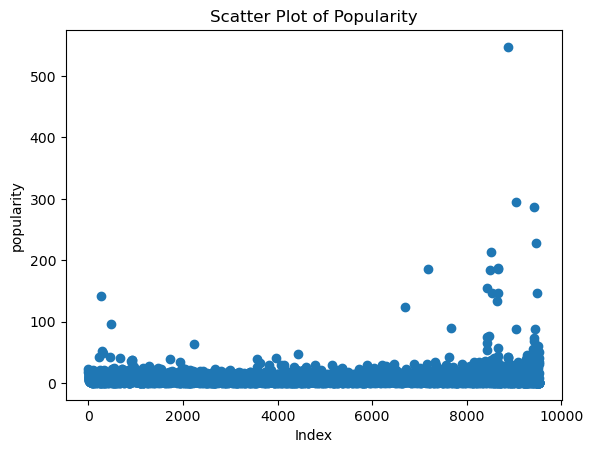

In [5]:
import matplotlib.pyplot as plt
plt.scatter(nb_df.index, nb_df['popularity'])

plt.xlabel('Index')  # Replace with the actual label for the x-axis
plt.ylabel('popularity')  # Replace with the actual label for the y-axis
plt.title('Scatter Plot of Popularity')

# Show the plot
plt.show()

I will use the “popularity” column as my target variable for this task, so I plotted a scatter plot to show the distribution of popularity points across the entire dataset. There are a handful of outlier points in the data, so my next task will be to remove these outliers to result with a more evenly spread dataset.

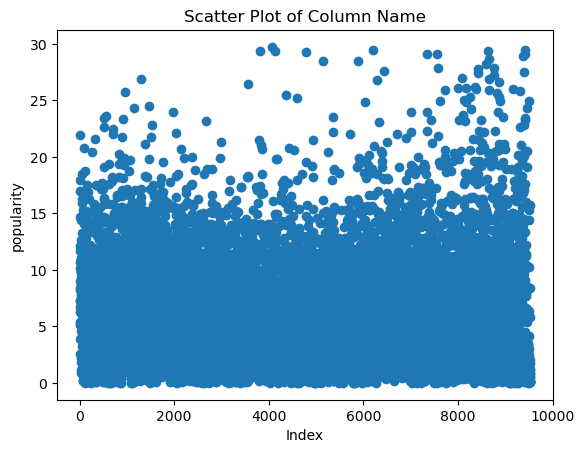

In [6]:
nb_df = nb_df[nb_df['popularity'] < 30]
plt.scatter(nb_df.index, nb_df['popularity'])
plt.xlabel('Index')
plt.ylabel('popularity') 
plt.title('Scatter Plot of Column Name')
plt.show()

After cutting off all datapoints with popularity greater than 30, I am left with a dataset with wider spread. I can now apply the feature selection.

In [7]:
nb_df
print(nb_df.isnull().sum())

avg_rating      0
budget          0
popularity      0
revenue         0
runtime         0
vote_average    0
vote_count      0
dtype: int64


In [8]:
bin_edges = [0, 10, 20, 30]
nb_df['popularity'] = pd.cut(nb_df['popularity'], bins=bin_edges, labels=['Low', 'Medium', 'High'])
nb_df.head()
file_path = './popularity_data_analysis.csv' 
nb_df.to_csv(file_path, index=False)

<br>
I binned the “popularity” column so that I now have levels: Low, Medium, High as my classes that I will use in the feature selection process.

Once the “popularity” column is transformed by binning, I will split my dataset into training and test sets. I then used the SelectKBest method from scikit-learn with the ANOVA F-statistic (f_classif) as the scoring function to select the top 5 features that are most strongly correlated with the target variable. This is based on the training data (X_train and y_train).
<br>
<br>

In [9]:
X = nb_df.drop('popularity', axis=1)
y = nb_df['popularity']
saved_df = X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
k_best_selector = SelectKBest(score_func=f_classif, k=5)
k_best_selector.fit(X_train, y_train)
selected_feature_indices = k_best_selector.get_support(indices=True)
X_train_selected = X_train.iloc[:, selected_feature_indices]
X_test_selected = X_test.iloc[:, selected_feature_indices]

<br>
After the feature selection and subsetting, I intialized a Gaussian Naive Bayes model (GaussianNB) and trained it using the subset of the training data with selected features. The code then uses the trained model to make predictions on the subset of the testing data and evaluates the accuracy of the predictions.
<br>
<br>

In [11]:
nb_df = GaussianNB()
nb_df.fit(X_train_selected, y_train)
selected_features = saved_df.columns[selected_feature_indices]
print(selected_features)

y_pred_train = nb_df.predict(X_train_selected)
training_accuracy = accuracy_score(y_train, y_pred_train)
print(f'Training Accuracy: {training_accuracy}')

y_pred_test = nb_df.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {test_accuracy}')

Index(['budget', 'revenue', 'runtime', 'vote_average', 'vote_count'], dtype='object')
Training Accuracy: 0.7790282007149477
Test Accuracy: 0.7850714663843303


## Evaluation Metrics ##

- **Accuracy:** Accuracy describes the proportion of correctly classified instances out of the entire dataset.

- **Precision:** #True positive predictions / #Total predicted positives.

- **Recall:** #True positive predictions / #Total actual positives.

- **F1-Score:** This is the harmonic mean of precision and recall. F1-Score is particularly useful when dealing with imbalanced datasets.

In [12]:
nb_df = GaussianNB()
cv_scores = cross_val_score(nb_df, X_train_selected, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))
nb_df.fit(X_train_selected, y_train)
y_pred_test = nb_df.predict(X_test_selected)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {accuracy_test}')

classification_rep = classification_report(y_test, y_pred_test)
print("Classification Report:")
print(classification_rep)

Cross-validation scores: [0.77961615 0.79086698 0.77432164 0.77880795 0.77086093]
Mean CV accuracy: 0.7788947278456879
Test Accuracy: 0.7850714663843303
Classification Report:
              precision    recall  f1-score   support

        High       0.31      0.44      0.36        27
         Low       0.82      0.95      0.88      1447
      Medium       0.55      0.25      0.34       415

    accuracy                           0.79      1889
   macro avg       0.56      0.55      0.53      1889
weighted avg       0.75      0.79      0.75      1889



The cross-validation scores represent the accuracy of my model on different subsets of the training data. The cross-validation scores range from approximately 77.08% to 79.09% across five subsets. The scores are relatively close to each other, which is a positive sign. It suggests that my model is consistent in its performance across different subsets of the training data. The mean cross-validation accuracy is calculated by averaging the individual cross-validation scores. The mean accuracy is approximately 77.89%. This provides a more stable estimate of how my model will perform on the training data. The test accuracy is approximately 78.51%. This is consistent with the mean cross-validation accuracy, which impies that my model will most-likely perform similarly on both the training data and new test datasets.

Given that my training accuracy and test accuracy scores are very close to each other, as well as my cross validation and test accuracy scores, I can infer that the model is not overfitting to the training data.

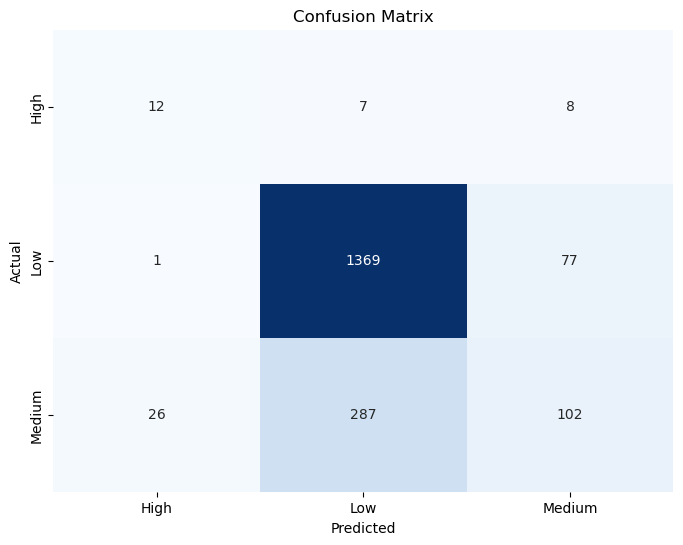

In [13]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
class_labels = ["High", "Low", "Medium"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Conclusion ##

In conclusion, the application of feature selection and the Naive Bayes classifier has yielded several notable observations and insights. The process of feature selection aimed to identify and retain the most informative variables from the dataset, contributing to enhanced model performance, reduced overfitting, and improved interpretability of results.

The Naive Bayes classifier, a probabilistic algorithm, demonstrated its effectiveness in handling the selected features for the given task. The evaluation metrics, including accuracy, precision, recall, and F1-score, provided a comprehensive understanding of the model’s performance across different classes. Notably, the model’s ability to accurately predict instances belonging to the “Low” class showcases its practical utility in identifying less-popular items or events.

However, it is crucial to acknowledge certain challenges encountered during the analysis. The imbalanced distribution among classes, as evidenced by varying precision and recall scores, highlights potential areas for model refinement, particularly in addressing the prediction of less-frequent outcomes.

Furthermore, the impact of feature selection on model interpretability is evident in the selected subset of features. Clear identification of influential factors contributing to predictions facilitates a more transparent understanding of the underlying decision-making process.

In summary, the combination of feature selection and the Naive Bayes classifier has provided valuable insights into the dataset. While achieving commendable overall accuracy, further exploration into class-specific metrics and potential strategies to address class imbalance could refine the model for real-world applications.